# APS1052 Final Project

The focus if this project is the seed model from the book Machine Learning and Data Science Blueprints for Finance. The goal this project is to use regression modelto predict the future price of an ETF/Stock. 


In [116]:
# Basic Tools
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from matplotlib import pyplot

# Feature Engineering
import talib as ta

# Feature Selection
from sklearn.feature_selection import SelectKBest, chi2, f_regression

# Machine Learning
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.preprocessing import FunctionTransformer
from sklearn import linear_model
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from scipy.stats import spearmanr


# Helpers
import helpers.fAux as fAux
import helpers.detrendPrice as detrendPrice
import helpers.WhiteRealityCheckFor1 as WhiteRealityCheckFor1

# Since there are 5 trading days in a week
return_period = 5
trading_days = 253


# 1.Data Preprocessing

## Clean Data

In [117]:
def clean(df):
    new_df = pd.DataFrame()
    new_df["Date"] = pd.to_datetime(df.iloc[:, 0])
    columns_to_clean = ["Open", "High", "Low", "Close", "Volume"]
    for col in columns_to_clean:
        new_df[col] = df[col].astype(str).str.replace(r'[\$,]', '', regex=True).astype(str).astype(float)
    return new_df


## Load data

In [118]:
# stocks
AAPL = clean(pd.read_csv('data/stock/AAPL.csv'))
AMD = clean(pd.read_csv('data/stock/AMD.csv'))
AMZN = clean(pd.read_csv('data/stock/AMZN.csv'))
GOOGL = clean(pd.read_csv('data/stock/GOOGL.csv'))
INTC = clean(pd.read_csv('data/stock/INTC.csv'))
MSFT = clean(pd.read_csv('data/stock/MSFT.csv'))
NVDA = clean(pd.read_csv('data/stock/NVDA.csv'))


# indices
SPY = clean(pd.read_csv('data/etf/SPY.csv'))
QQQ = clean(pd.read_csv('data/etf/QQQ.csv'))
IEF = clean(pd.read_csv('data/etf/IEF.csv'))

# Use TSLA as testing etf to determine the effective of our model
TSLA = clean(pd.read_csv('data/stock/TSLA.csv'))

stocks = [AAPL, AMD, AMZN, GOOGL, INTC, MSFT, NVDA, TSLA, SPY, QQQ]

In [119]:
AAPL

,Date,Open,High,Low,Close,Volume
0,2025-03-07,235.1050,241.3700,234.7600,239.0700,46273570.0
1,2025-03-06,234.4350,237.8600,233.1581,235.3300,45170420.0
2,2025-03-05,235.4200,236.5500,229.2300,235.7400,47227640.0
3,2025-03-04,237.7050,240.0700,234.6800,235.9300,53798060.0
4,2025-03-03,241.7900,244.0272,236.1120,238.0300,47183990.0
...,...,...,...,...,...,...
2511,2015-03-13,31.1000,31.3488,30.6450,30.8975,206978680.0
2512,2015-03-12,30.5775,31.2250,30.4075,31.1125,192933080.0
2513,2015-03-11,31.1875,31.1925,30.5275,30.5600,275250760.0
2514,2015-03-10,31.6025,31.8050,30.9500,31.1275,274881440.0


In [120]:
print(AAPL.dtypes)

Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume           float64
dtype: object


# Feature Engineering

In [121]:
def get_indicator(df, indicators):
    if indicators is None:
        indicators = ['MACD', 'MFI', 'SMA', 'MOM', 'ROC', 'RSI', 'ATR', 'BBANDS']

    timeperiod = 5

    # Create a copy to avoid modifying the original DataFrame
    df = df.copy()

    # Moving Average Convergence Divergence (MACD)
    if 'MACD' in indicators:
        macd, macdsignal, macdhist = ta.MACD(df['Close'].values, fastperiod=12, slowperiod=26, signalperiod=9)
        df['MACD_Diff'] = macd
        df['MACD_Signal'] = macdsignal
        df['MACD_Hist'] = macdhist

    # Money Flow Index (MFI)
    if 'MFI' in indicators:
        df['MFI'] = ta.MFI(df['High'].values, df['Low'].values, df['Close'].values, df['Volume'].values, timeperiod=timeperiod)

    # Simple Moving Average (SMA)
    if 'SMA' in indicators:
        df['SMA_20'] = ta.SMA(df['Close'].values, timeperiod=20)
        df['SMA_50'] = ta.SMA(df['Close'].values, timeperiod=50)

    # Momentum Indicator (MOM)
    if 'MOM' in indicators:
        df['MOM'] = ta.MOM(df['Close'].values, timeperiod=timeperiod)

    # Rate of Change (ROC)
    if 'ROC' in indicators:
        df['ROC'] = ta.ROC(df['Close'].values, timeperiod=timeperiod)

    # Relative Strength Index (RSI)
    if 'RSI' in indicators:
        df['RSI'] = ta.RSI(df['Close'].values, timeperiod=timeperiod)

    # Average True Range (ATR)
    if 'ATR' in indicators:
        df['ATR'] = ta.ATR(df['High'].values, df['Low'].values, df['Close'].values, timeperiod=timeperiod)

    # Bollinger Bands (BBANDS)
    if 'BBANDS' in indicators:
        df['Upper_BB'], df['Middle_BB'], df['Lower_BB'] = ta.BBANDS(df['Close'].values, timeperiod=20)

    # Fill NaN values generated by TA-Lib
    df.fillna(method='bfill', inplace=True)  # Backfill missing values

    return df

In [ ]:
column_names = ["AAPL", "AMD", "AMZN", "GOOGL", "INTC", "MSFT", "NVDA", "SPY", "QQQ", "TSLA_pred"]

appended_data = []
for stock, name in zip(stocks, column_names):
    temp = pd.DataFrame(np.log(stock["Close"]).diff(return_period).shift(-return_period))
    temp.columns = [name]
    appended_data.append(temp)

dataset = pd.concat(appended_data, axis=1)

multipliers = [2, 4, 6, 10]

tsla_lags = pd.concat(
    [np.log(TSLA["Close"]).diff(return_period * m) for m in multipliers],
    axis=1
)
tsla_lags.columns = [f"TSLA_{return_period * m}" for m in multipliers]

combined_df = pd.concat([dataset, tsla_lags], axis=1)
clean_df = combined_df.dropna()
sampled_df = clean_df.iloc[::return_period, :]
full_data = sampled_df.reset_index(drop=True)

Y = full_data[["TSLA_pred"]]
X = full_data.drop('TSLA_pred', axis=1)

p1=pd.DataFrame(np.log(SPY['Close']))
p2=pd.DataFrame(np.log(IEF['Close']))
mfi=(p1.subtract(p2).dropna()).rolling(20).mean()
mfi.columns = ['Mfi']
X = X.join(mfi)

tsl = get_indicator(TSLA, ['SMA','ROC','MOM'])
X = X.join(tsl.iloc[:,-5:])
X = X.fillna(X.mean())
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=0)

/var/folders/9g/28x2cnp16b547zblzb11k4qh0000gn/T/ipykernel_45086/186933706.py:47: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)  # Backfill missing values


In [123]:
X

,AAPL,AMD,AMZN,GOOGL,INTC,MSFT,NVDA,SPY,QQQ,TSLA_10,TSLA_20,TSLA_30,TSLA_50,Mfi,Volume,SMA_20,SMA_50,MOM,ROC
0,-0.025309,0.062592,0.011230,-0.008341,0.041150,0.024145,-0.003346,0.035394,0.021852,0.065511,0.020830,0.117664,0.471877,1.664640,102369600.0,317.8490,371.7132,30.31,11.539194
1,-0.021550,0.088042,-0.001892,-0.082949,0.028116,-0.008307,0.059217,-0.114025,0.005941,0.044101,0.018533,0.086005,0.398065,1.664640,98451570.0,317.8490,371.7132,30.31,11.539194
2,-0.022951,-0.010262,-0.088073,-0.033525,0.139429,-0.046397,-0.029857,-0.120137,-0.008692,-0.078631,-0.013119,-0.057801,0.141691,1.664640,94042910.0,317.8490,371.7132,30.31,11.539194
3,-0.037828,0.002294,-0.046825,-0.007844,0.016086,-0.025326,0.059122,-0.016122,-0.014847,-0.234162,-0.190061,-0.215629,-0.030754,1.664640,126706600.0,317.8490,371.7132,30.31,11.539194
4,-0.001314,0.009771,0.063946,0.046336,0.023854,0.033394,0.000613,-0.087515,-0.000539,-0.136259,-0.214889,-0.149378,-0.097225,1.664640,115551400.0,317.8490,371.7132,30.31,11.539194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488,-0.002299,0.011173,-0.028178,0.009367,-0.007331,-0.002885,-0.022615,-0.020504,-0.010605,-0.105221,-0.165255,-0.176185,-0.245430,1.416860,120851600.0,185.0425,181.3552,-2.96,-1.519741
489,0.002853,0.000000,0.000481,0.029434,0.006378,-0.013820,-0.018095,-0.064415,0.004669,-0.029860,-0.136387,-0.195518,-0.247822,1.414349,116531600.0,186.4355,180.7372,-17.05,-8.218452
490,0.006625,0.050552,0.001387,0.007517,-0.008299,0.045226,0.056330,0.046446,0.008368,-0.084919,-0.190140,-0.250174,-0.274233,1.411336,144193900.0,187.7925,180.2294,-3.06,-1.566981
491,-0.017926,-0.028573,-0.004703,-0.006619,-0.011930,-0.030684,0.011383,-0.019883,-0.006785,-0.017969,-0.047828,-0.154356,-0.220943,1.408634,150376400.0,189.2005,179.7730,-2.73,-1.408087


In [124]:
Y

,TSLA_pred
0,0.022628
1,-0.007663
2,-0.032313
3,-0.009382
4,0.007320
...,...
488,-0.012866
489,0.008752
490,0.014788
491,-0.015069


## Feature scaling

In [125]:
from sklearn.preprocessing import StandardScaler
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=1)

scaler = StandardScaler()
scaler.fit(y_train)

# transform training dataset
scaler.fit(x_train)
x_train = pd.DataFrame(scaler.transform(x_train))
scaler.fit(x_test)
x_test = pd.DataFrame(scaler.transform(x_test))

# transform test dataset
scaler.fit(y_train)
y_train = pd.DataFrame(scaler.transform(y_train))
scaler.fit(y_test)
y_test = pd.DataFrame(scaler.transform(y_test))

In [126]:
X

,AAPL,AMD,AMZN,GOOGL,INTC,MSFT,NVDA,SPY,QQQ,TSLA_10,TSLA_20,TSLA_30,TSLA_50,Mfi,Volume,SMA_20,SMA_50,MOM,ROC
0,-0.025309,0.062592,0.011230,-0.008341,0.041150,0.024145,-0.003346,0.035394,0.021852,0.065511,0.020830,0.117664,0.471877,1.664640,102369600.0,317.8490,371.7132,30.31,11.539194
1,-0.021550,0.088042,-0.001892,-0.082949,0.028116,-0.008307,0.059217,-0.114025,0.005941,0.044101,0.018533,0.086005,0.398065,1.664640,98451570.0,317.8490,371.7132,30.31,11.539194
2,-0.022951,-0.010262,-0.088073,-0.033525,0.139429,-0.046397,-0.029857,-0.120137,-0.008692,-0.078631,-0.013119,-0.057801,0.141691,1.664640,94042910.0,317.8490,371.7132,30.31,11.539194
3,-0.037828,0.002294,-0.046825,-0.007844,0.016086,-0.025326,0.059122,-0.016122,-0.014847,-0.234162,-0.190061,-0.215629,-0.030754,1.664640,126706600.0,317.8490,371.7132,30.31,11.539194
4,-0.001314,0.009771,0.063946,0.046336,0.023854,0.033394,0.000613,-0.087515,-0.000539,-0.136259,-0.214889,-0.149378,-0.097225,1.664640,115551400.0,317.8490,371.7132,30.31,11.539194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488,-0.002299,0.011173,-0.028178,0.009367,-0.007331,-0.002885,-0.022615,-0.020504,-0.010605,-0.105221,-0.165255,-0.176185,-0.245430,1.416860,120851600.0,185.0425,181.3552,-2.96,-1.519741
489,0.002853,0.000000,0.000481,0.029434,0.006378,-0.013820,-0.018095,-0.064415,0.004669,-0.029860,-0.136387,-0.195518,-0.247822,1.414349,116531600.0,186.4355,180.7372,-17.05,-8.218452
490,0.006625,0.050552,0.001387,0.007517,-0.008299,0.045226,0.056330,0.046446,0.008368,-0.084919,-0.190140,-0.250174,-0.274233,1.411336,144193900.0,187.7925,180.2294,-3.06,-1.566981
491,-0.017926,-0.028573,-0.004703,-0.006619,-0.011930,-0.030684,0.011383,-0.019883,-0.006785,-0.017969,-0.047828,-0.154356,-0.220943,1.408634,150376400.0,189.2005,179.7730,-2.73,-1.408087


In [127]:
x_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.640513,0.574957,-0.351954,0.494966,-0.084756,-0.276735,1.235577,0.250814,-0.834070,-0.616786,0.132443,-0.201311,0.112607,-0.929585,0.463295,-0.180712,-0.282991,0.023357,0.009554
1,0.097149,-0.190989,-0.431722,0.427413,0.623814,-0.041732,-0.785931,-0.431742,-0.730069,0.972507,0.928870,1.084031,0.597873,1.488075,-0.284522,2.272173,1.695909,0.309995,0.174775
2,-0.251963,-0.790863,-0.810497,-0.269333,-0.256550,-0.865722,-0.589564,-0.737822,-0.747373,-2.198759,-0.971428,-1.145357,-0.651272,0.438018,0.350681,-0.366271,-0.447283,1.532664,1.847552
3,-0.182667,1.159708,0.843818,0.983677,0.170006,-0.208588,-0.047726,0.277962,0.705231,1.409024,1.340526,0.714035,0.671097,-1.865024,0.569048,-1.052358,-0.518978,-0.310493,-0.473625
4,-0.204156,-0.209522,1.030928,-2.445373,-0.485248,-0.464874,-0.150561,1.075031,-0.459401,0.379736,0.698508,0.251200,0.218201,0.010204,0.940142,-0.741879,-1.039679,-0.374083,-0.521084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,0.345205,0.754022,-0.532925,0.048217,-0.198434,-0.218795,-0.497180,1.169247,-0.228489,-0.448718,-1.346944,-1.494247,-2.835455,0.187350,-0.584342,-0.969998,-1.157014,1.085605,1.589585
242,-0.655731,-0.171901,-0.768202,-0.689284,-0.301264,-1.512961,-0.925912,-0.711019,-0.850829,1.279066,1.619884,0.830816,0.896576,1.389219,-0.491543,1.893704,2.087920,0.340827,0.241438
243,-0.585655,-1.449861,0.473583,-0.459115,0.094261,0.244959,-0.460956,-0.493405,-0.238766,0.332976,0.560649,0.378135,-0.278280,-0.925039,-0.246121,-0.083200,-0.041912,0.772952,0.857034
244,0.975367,-0.181419,-0.508381,0.031675,-0.448492,-0.176006,-0.127118,0.069390,-0.133729,-0.422432,-0.431338,-0.526187,-1.551028,0.282401,-0.844332,-1.162154,-1.162519,0.491131,0.783772


In [128]:
def ewm_smoother(x_train, span=None):
    if not isinstance(x_train, pd.DataFrame):
        x_train = pd.DataFrame(x_train)
    
    to_smooth = x_train.iloc[:, :-6]
    unsmoothed = x_train.iloc[:, -6:]
    
    smoothed = to_smooth.ewm(span=span, adjust=True).mean()
    
    result = pd.concat([smoothed, unsmoothed], axis=1)
    return result.values
    
def sharpe(y_true, y_pred):
    positions = np.where(y_pred > 0, 1, -1)
    
    shifted_positions = np.empty_like(positions)
    shifted_positions[0] = 0
    shifted_positions[1:] = positions[:-1]
    
    daily_ret = shifted_positions * y_true
    daily_ret = np.nan_to_num(daily_ret)
    
    annualization_factor = (trading_days/return_period)**0.5
    ratio = annualization_factor * np.mean(daily_ret) / np.std(daily_ret)
    return ratio

myscorer = make_scorer(sharpe, greater_is_better=True)

smoother = FunctionTransformer(ewm_smoother, validate=False)
lasso = linear_model.Lasso()
pipe = Pipeline([("smoother", smoother), ("lasso", lasso)])

param_grid = [
                {'smoother__kw_args': [{'span': i} for i in range(1, 21)], 
                'lasso__alpha': np.linspace(0.001, 1, num=30, endpoint=True)}
            ]

split = TimeSeriesSplit(n_splits = 5, max_train_size = 20000)
grid_search = RandomizedSearchCV(pipe, param_grid, cv=split, scoring=myscorer, return_train_score=True)

In [129]:
grid_search.fit(x_train.values, y_train.values.ravel())

best_parameters = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best model scaling grid: {}".format(best_model))
print("Best parameters scaling grid: {}".format(best_parameters))
print("Best cross-validation score scaling grid: {:.2f}".format(grid_search.best_score_*100))
results = pd.DataFrame(grid_search.cv_results_)

true_y = y_test.values.ravel()
pred_y = best_model.predict(x_test.values)

Best model scaling grid: Pipeline(steps=[('smoother',
                 FunctionTransformer(func=<function ewm_smoother at 0x1761140d0>,
                                     kw_args={'span': 2})),
                ('lasso', Lasso(alpha=0.035448275862068966))])
Best parameters scaling grid: {'smoother__kw_args': {'span': 2}, 'lasso__alpha': 0.035448275862068966}
Best cross-validation score scaling grid: -15.99


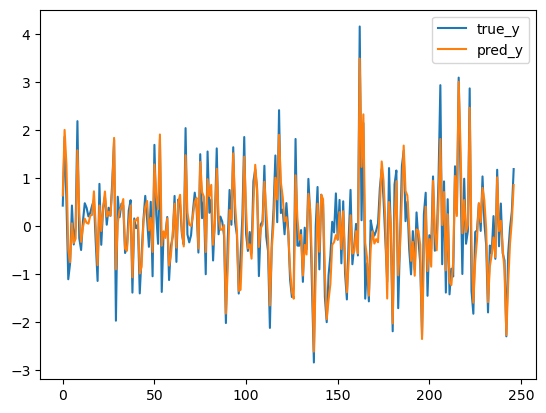

In [130]:
pyplot.plot(true_y, label='true_y')
pyplot.plot(pred_y, label='pred_y')
pyplot.legend()
pyplot.show()

# Validation

In [131]:
from scipy.special import ndtr
from sklearn.metrics import accuracy_score
from phik.report import plot_correlation_matrix

df_ret = TSLA.iloc[Y.index.values]['Close'].pct_change(periods=1).fillna(0)

In [132]:
df_ret1 = df_ret.reset_index(drop= True)[:x_train.shape[0],]
df_ret2 = df_ret.reset_index(drop= True)[x_train.shape[0]:,]

In [133]:
positions = np.where(grid_search.predict(x_train.values)> 0,1,-1 ) 
dailyRet = pd.Series(positions).shift(1).fillna(0).values * df_ret1
dailyRet = dailyRet.fillna(0)
cumret = np.array(np.cumprod(dailyRet + 1) - 1)

# plt.figure(2)
# plt.plot(cumret2.index, cumret2)
# plt.title('Cross-validated LogisticRegression on currency: test set')
# plt.ylabel('Cumulative Returns')
# plt.xlabel('Date')
# #plt.show()
# plt.savefig(r'Results\%s.png' %("TestCumulative2"))

# #metrics
# accuracy_score = accuracy_score(y_test.values.ravel(), grid_search.predict(x_test.values))

# #If this figure does not plot correctly select the lines and press F9 again
# arr1 = y_test.values.ravel()
# arr2 = grid_search.predict(x_test.values)
# dfc = pd.DataFrame({'y_true': arr1, 'y_pred': arr2})
# phi_k_corr = dfc.phik_matrix(interval_cols=[]).iloc[1,0]
# significance_overview = dfc.significance_matrix(interval_cols=[])
# phi_k_sig  = dfc.significance_matrix(interval_cols=[]).iloc[1,0]
# phi_k_p_val = 1 - ndtr(phi_k_sig) 
# plot_correlation_matrix(significance_overview.fillna(0).values, 
#                         x_labels=significance_overview.columns, 
#                         y_labels=significance_overview.index, 
#                         vmin=-5, vmax=5, title="Significance of the coefficients", 
#                         usetex=False, fontsize_factor=1.5, figsize=(7, 5))
# plt.tight_layout()
# #plt.show()
# plt.savefig(r'Results\%s.png' %("Significance2"))

rho, pval = spearmanr(y_test,grid_search.predict(x_test.values)) #spearman's rank correlation: very small but significant

cagr = (1 + cumret[-1]) ** ((trading_days/return_period) / len(cumret)) - 1
maxDD, maxDDD = fAux.calculateMaxDD(cumret)
ratio = ((trading_days/return_period) ** (1.0/2.0)) * np.mean(dailyRet) / np.std(dailyRet)
print (('In-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6} Rho={:0.6} PVal={:0.6}\n'\
    ).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD, rho, pval))


In-sample: CAGR=-0.148392 Sharpe ratio=-0.42452 maxDD=-0.666734 maxDDD=232 Calmar ratio=-0.222565 Rho=0.900268 PVal=1.83733e-90



In [134]:
positions2 = np.where(grid_search.predict(x_test.values)> 0,1,-1 )

dailyRet2 = pd.Series(positions2).shift(1).fillna(0).values * df_ret2
dailyRet2 = dailyRet2.fillna(0)

cumret2 = np.array(np.cumprod(dailyRet2 + 1) - 1)

# plt.figure(2)
# plt.plot(cumret2.index, cumret2)
# plt.title('Cross-validated LogisticRegression on currency: test set')
# plt.ylabel('Cumulative Returns')
# plt.xlabel('Date')
# #plt.show()
# plt.savefig(r'Results\%s.png' %("TestCumulative2"))

# #metrics
# accuracy_score = accuracy_score(y_test.values.ravel(), grid_search.predict(x_test.values))

# #If this figure does not plot correctly select the lines and press F9 again
# arr1 = y_test.values.ravel()
# arr2 = grid_search.predict(x_test.values)
# dfc = pd.DataFrame({'y_true': arr1, 'y_pred': arr2})
# phi_k_corr = dfc.phik_matrix(interval_cols=[]).iloc[1,0]
# significance_overview = dfc.significance_matrix(interval_cols=[])
# phi_k_sig  = dfc.significance_matrix(interval_cols=[]).iloc[1,0]
# phi_k_p_val = 1 - ndtr(phi_k_sig) 
# plot_correlation_matrix(significance_overview.fillna(0).values, 
#                         x_labels=significance_overview.columns, 
#                         y_labels=significance_overview.index, 
#                         vmin=-5, vmax=5, title="Significance of the coefficients", 
#                         usetex=False, fontsize_factor=1.5, figsize=(7, 5))
# plt.tight_layout()
# #plt.show()
# plt.savefig(r'Results\%s.png' %("Significance2"))

rho, pval = spearmanr(y_test,grid_search.predict(x_test.values)) #spearman's rank correlation: very small but significant

cagr = (1 + cumret2[-1]) ** ((trading_days/return_period) / len(cumret2)) - 1
maxDD, maxDDD = fAux.calculateMaxDD(cumret2)
ratio = ((trading_days/return_period) ** (1.0/2.0)) * np.mean(dailyRet2) / np.std(dailyRet2)
print (('Out-of-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}  Rho={:0.6} PVal={:0.6}\n'\
).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD, rho, pval))


Out-of-sample: CAGR=0.0221333 Sharpe ratio=0.208953 maxDD=-0.441367 maxDDD=120 Calmar ratio=0.0501471  Rho=0.900268 PVal=1.83733e-90



In [135]:
positionsytrain = np.where(y_train.values.ravel() > 0,1,-1 )
dailyRetytrain = pd.Series(positionsytrain).shift(1).fillna(0).values * df_ret1
dailyRetytrain = dailyRetytrain.fillna(0)
cumretytrain = np.array(np.cumprod(dailyRetytrain + 1) - 1)

positionsytest = np.where(y_test.values.ravel() > 0,1,-1 )
dailyRetytest = pd.Series(positionsytest).shift(1).fillna(0).values * df_ret2
dailyRetytest = dailyRetytest.fillna(0)
cumretytest = np.array(np.cumprod(dailyRetytest + 1) - 1)

dates = TSLA.iloc[Y.index.values]['Date']
dates= dates.reset_index(drop= True)[:x_train.shape[0],]



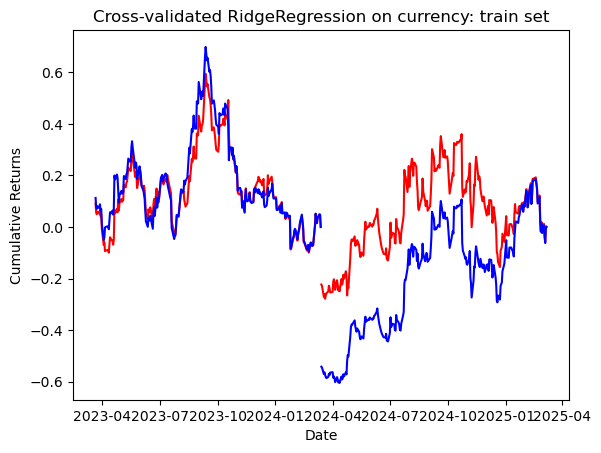

In [136]:

pyplot.figure(1)
pyplot.plot(dates, cumretytrain ,'r')
pyplot.plot(dates, cumret,'b')
pyplot.title('Cross-validated RidgeRegression on currency: train set')
pyplot.ylabel('Cumulative Returns')
pyplot.xlabel('Date')

dates = TSLA.iloc[Y.index.values]['Date']
dates= dates.reset_index(drop= True)[x_train.shape[0]:,]
pyplot.plot(dates, cumretytest ,'red')
pyplot.plot(dates, cumret2,'b')


## white reality check

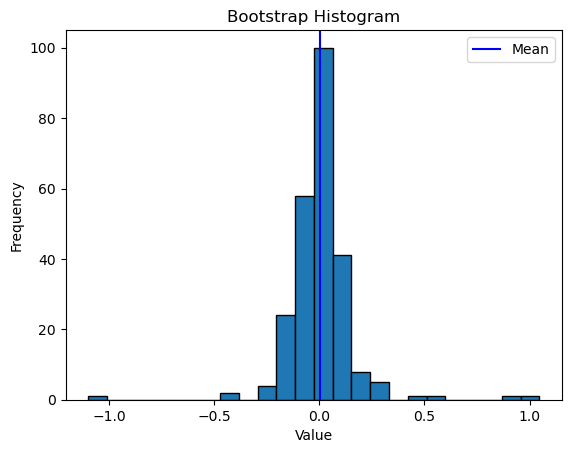

Bootstrap 95% CI for the mean: [-0.0132, 0.0249]


In [137]:
new_close = TSLA.iloc[Y.index.values]['Close'].reset_index(drop=True)[(x_train.shape[0]):,]
detrended_close = detrendPrice.detrendPrice(new_close)
detrended_ret1 = detrended_close.pct_change(periods=1).fillna(0)
detrended_syst_rets = detrended_ret1 * pd.Series(positions2).shift(1).fillna(0)
WhiteRealityCheckFor1.bootstrap(detrended_syst_rets)


In [138]:
# Train error
train_result = mean_squared_error(grid_search.predict(x_train), y_train)
test_result = mean_squared_error(grid_search.predict(x_test), y_test)
print("train_result:",train_result, "test_result",test_result)


train_result: 0.14692297455673456 test_result 0.14940291538312567
